In [31]:
%load_ext autoreload
%autoreload 2
from naml.modules import torch, nn, optim, tqdm
from naml import plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sequence masking

In [32]:
# You can unsqueeze the tensor ..like this?
# Adding a singleton dimension of None will add a dimension of size 1
a = torch.arange(10)
print(a.unsqueeze(0), a.unsqueeze(1))
print(a[None, :], a[:, None])

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]) tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]) tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])


In [33]:
from naml.modules.sequence import sequence_mask

In [34]:
seq = (torch.arange(10) + 1).reshape(2, 5)
lens = torch.tensor([2, 3])
sequence_mask(seq, lens, 0)

tensor([[1, 2, 0, 0, 0],
        [6, 7, 8, 0, 0]])

In [35]:
from naml.modules.sequence import softmax_mask
softmax_mask(torch.rand(2, 2, 4), torch.tensor([2, 3])), softmax_mask(torch.rand(2, 2, 4), torch.tensor([[1,3], [2, 4]]))

(tensor([[[0.5768, 0.4232, 0.0000, 0.0000],
          [0.4759, 0.5241, 0.0000, 0.0000]],
 
         [[0.3570, 0.2368, 0.4062, 0.0000],
          [0.2844, 0.2515, 0.4640, 0.0000]]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.2599, 0.4448, 0.2954, 0.0000]],
 
         [[0.4482, 0.5518, 0.0000, 0.0000],
          [0.2988, 0.2714, 0.1581, 0.2717]]]))

## Additive Attention

$$
a(\mathbf{q},\mathbf{k}) = \mathbf{w_v}^T \tanh(\mathbf{W_q q} + \mathbf{W_k k})
$$

Basically a MLP with $W_q, W_k, w_v$ as parameters

In [36]:
from naml.modules.attention import AdditiveAttention

q, k = torch.normal(0, 1, (2, 1, 20)), torch.ones((2,10,2))
v = torch.arange(40).reshape(1, 10, 4).repeat(2, 1, 1).float() # Tiles
lens = torch.tensor([2, 6])
attn = AdditiveAttention(n_key=2, n_query=20, n_hidden=8, dropout_p=0.1)
attn.eval() # No grad & no dropout
attn(q, k, v, lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<UnsafeViewBackward0>)

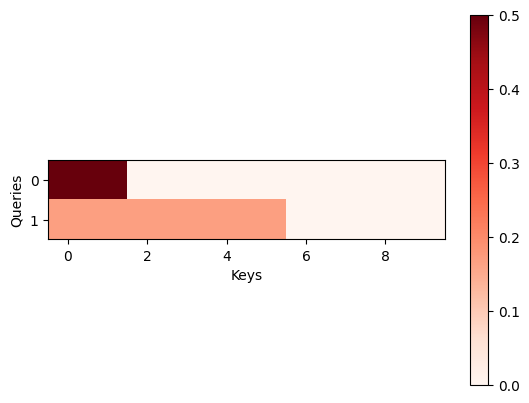

In [37]:
plot.heatmap(attn.M_w.reshape((2,10)),label_x="Keys",label_y="Queries")

## Dot Product Attention
$$a(\mathbf{q,k}) = \frac{\mathbf{Q} \mathbf{K}^T}{\sqrt{d}}, \text{where}\ \mathbf{d}\ \text{is sequence length for both query and key}$$

In [38]:
from naml.modules.attention import DotProductAttention
   
q = torch.normal(0, 1, (2, 1, 2))
attn = DotProductAttention(dropout_p=0.1)
attn.eval() # No grad & no dropout
attn(q, k, v, lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

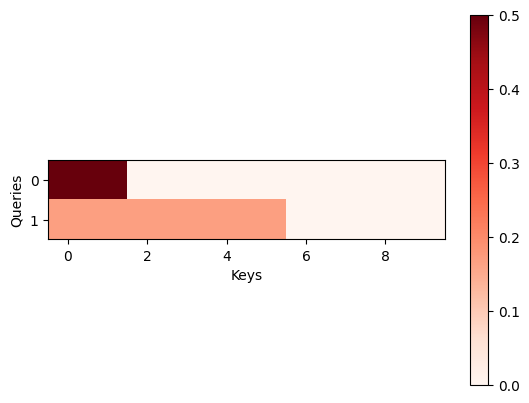

In [39]:
plot.heatmap(attn.M_w.reshape((2,10)),label_x="Keys",label_y="Queries")

- With the same query key length Dot Prod & Additive are equivalent
- Dot Prod is more efficient in this case 